In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

In [82]:
# lOADING
train_test = pd.read_csv("../processing_2/data_all.csv", parse_dates=['Date'])

In [83]:
train_test

,Campagne,Region,Site,Famille,Variete,Num Parcelle,CodeTracabilite,Date,Tonnage,is_train,...,Id,Date Plantation,Date Arrachage,Porte Greffe,Sup Debut Camp,Sup Plantee,Sup Arrachee,Sup Fin Camp,Tree Age,Days to Arrachage
0,20/21,GHARB,Chorf Laghouazi,CLA,CLA1,13030,TR11130,2020-10-01,"269,855",True,...,1,2015-01-09,2060-09-30,PG6,1.7499,0.0,0.0,1.7499,2092.0,14609.0
1,20/21,GHARB,Chorf Laghouazi,CLA,CLA6,18030,TR11140,2020-10-01,"101605,9951",True,...,2,2017-05-20,NaN,PG6,1.0930,0.0,0.0,1.0930,1230.0,NaN
2,20/21,GHARB,Chorf Laghouazi,CLA,CLA12,13010,TR11120,2020-10-01,"170,354",True,...,3,2015-01-08,2021-01-11,PG6,2.3674,0.0,0.0,2.3674,2093.0,102.0
3,20/21,GHARB,Chorf Laghouazi,CLA,CLA14,12010,TR11090,2020-10-01,"37891,08567",True,...,4,2009-07-30,NaN,PG6,3.5341,0.0,0.0,3.5341,4081.0,NaN
4,20/21,GHARB,Chorf Laghouazi,CLA,CLA14,12020,TR11100,2020-10-01,"45197,56034",True,...,5,2009-07-30,NaN,PG7,1.6688,0.0,0.0,1.6688,4081.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938,22/23,SOUSS,Ouled Abbou,SPA,SPA4,21071,TR21071,2023-09-01,NaN,False,...,3896,2018-04-25,NaN,PG7,1.6000,0.0,0.0,1.6000,1955.0,NaN
3939,22/23,SOUSS,Ouled Abbou,SPA,SPA5,21021,TR21021,2023-09-01,NaN,False,...,3897,2017-07-23,2050-07-23,PG7,1.1572,0.0,0.0,1.1572,2231.0,9822.0
3940,22/23,SOUSS,Ouled Abbou,SPA,SPA6,21121,TR21121,2023-09-01,NaN,False,...,3898,2019-03-16,NaN,PG7,0.6973,0.0,0.0,0.6973,1630.0,NaN
3941,22/23,SOUSS,Ouled Abbou,SPA,SPA7,21081,TR21081,2023-09-01,NaN,False,...,3899,2018-04-16,NaN,PG7,3.4000,0.0,0.0,3.4000,1964.0,NaN


In [84]:
len(train_test)

3943

In [85]:
# Tonnage to float
train_test['Tonnage'] = train_test['Tonnage'].str.replace(',', '.').astype(float)

# Split the date
train_test['Year'] = train_test['Date'].dt.year
train_test['Month'] = train_test['Date'].dt.month
train_test['Day'] = train_test['Date'].dt.day


duplicates = train_test.duplicated(['CodeTracabilite', 'Num Parcelle', 'Campagne', 'Region', 'Site', 'Famille', 'Variete', 'Recolte'], keep=False)

# Then, apply the condition
condition = (train_test['Sup Debut Camp'] + train_test['Sup Plantee'] != train_test['Sup Arrachee'] + train_test['Sup Fin Camp'])

# Combine both conditions
to_drop = duplicates & condition

# Drop the rows that satisfy both conditions
train_test = train_test[~to_drop]

In [86]:
for month_index in range(12):
    train_test[f'irrigation_cumulee_{month_index + 1}'] = train_test[f'irrigation_cumulee_{month_index + 1}'].replace(0, np.nan)
    # train_test[f'N_cumulee_{month_index + 1}'] = train_test[f'N_cumulee_{month_index + 1}'].replace(0, np.nan)
    # train_test[f'P_cumulee_{month_index + 1}'] = train_test[f'P_cumulee_{month_index + 1}'].replace(0, np.nan)
    # train_test[f'K_cumulee_{month_index + 1}'] = train_test[f'K_cumulee_{month_index + 1}'].replace(0, np.nan)

C:\Users\DataScience\AppData\Local\Temp\ipykernel_77364\1869749954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test[f'irrigation_cumulee_{month_index + 1}'] = train_test[f'irrigation_cumulee_{month_index + 1}'].replace(0, np.nan)


In [87]:
# train_test[train_test['N_cumulee_1'].isna()]

In [88]:
# for month_index in range(12):
#     # print(f'Len irrigation {month_index + 1}:', len(train_test[train_test[f'irrigation_cumulee_{month_index + 1}'] == 0]))
#     print(f'Len irrigation {month_index + 1}:', len(train_test[train_test[f'irrigation_cumulee_{month_index + 1}'].isna()]))

In [89]:
irrigation_columns = [f'irrigation_cumulee_{i}' for i in range(1, 13)]

# Calculate the median for these columns in each row
row_medians = train_test[irrigation_columns].mean(axis=1)

# Replace NaN values in each column with the row median
for col in irrigation_columns:
    train_test[col] = train_test[col].fillna(row_medians)

C:\Users\DataScience\AppData\Local\Temp\ipykernel_77364\3993060754.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test[col] = train_test[col].fillna(row_medians)


In [90]:
# for index in range(12):
#     print('na irrigation', index + 1, len(train_test[train_test[f'irrigation_cumulee_{index + 1}'].isna()]))
#     print('na N_cummulee', index + 1, len(train_test[train_test[f'N_cumulee_{index + 1}'].isna()]))
#     print('na N_cumulee ', index + 1, len(train_test[train_test[f'P_cumulee_{index + 1}'].isna()]))
#     print('na K_cumulee', index + 1, len(train_test[train_test[f'K_cumulee_{index + 1}'].isna()]))
#     print("➖➖➖➖➖➖➖➖")

In [91]:
# cat_cols = ['Variete', 'Year', 'Region', 'Site', 'Porte Greffe', 'Month']
cat_cols = ['Variete', 'Porte Greffe']

num_cols = ['Sup Debut Camp', 'Tree Age', 'Days to Arrachage', 'Recolte']

for index in range(12):
    num_cols.append(f'irrigation_cumulee_{index + 1}')
    num_cols.append(f'N_cumulee_{index + 1}')
    num_cols.append(f'P_cumulee_{index + 1}')
    num_cols.append(f'K_cumulee_{index + 1}')

target_col = ['Tonnage']

all_feature_cols = num_cols + cat_cols

In [92]:
print(f'''
      ▶️ Len nan sup debut camp      : {len(train_test[train_test['Sup Debut Camp'].isna()])}
      ▶️ Len nan Sup Plantee         : {len(train_test[train_test['Sup Plantee'].isna()])}
      ▶️ Len nan Sup Arrachee        : {len(train_test[train_test['Sup Arrachee'].isna()])}
      ▶️ Len nan Sup Fin Camp        : {len(train_test[train_test['Sup Fin Camp'].isna()])}
      ▶️ Len nan Days to Arrachage   : {len(train_test[train_test['Days to Arrachage'].isna()])}
      ▶️ Len nan Tree Age            : {len(train_test[train_test['Tree Age'].isna()])}
''')


      ▶️ Len nan sup debut camp      : 365
      ▶️ Len nan Sup Plantee         : 365
      ▶️ Len nan Sup Arrachee        : 365
      ▶️ Len nan Sup Fin Camp        : 365
      ▶️ Len nan Days to Arrachage   : 2595
      ▶️ Len nan Tree Age            : 467



for day to arachage, i'll apply the median 
for others i need to see the distribution of these nan values, then decide


Pour sup debut camp:365
- these are the regions of nan values: ['HAOUZ', 'SOUSS', 'TADLA', 'ORIENTAL']
    - HAOUZ: 300
        - these NaN are in these 3 Site: ['Marrakech', 'Ait Ourir', 'Ouled Moussa']
            - Marrakech: 62
            - Ait Ourir: 1
            - Ouled Moussa: 237  (whereas 225 others are not NaN)
    - SOUSS: 17
    - Tadla: 47
    - ORENTAL: 1

    ▶️ I'll use KNN 

conclusion: les nan values de Sup Fin Camp, Sup Arrachee, Sup Plantee, Sup debut comp se coincide

    ▶️ I'll use for all of them KNN

- Tadla: 47 sameas sup debut camp
- Oriental: 1  sameas sup debut camp
- Gharb: 1
- SOUSS: 29   Not too uch compared with the none nan vals
- HAOUZ: 390
    - Ouled Moussa: 237 (same thing)
    - Lalla Takerkoust: 4
    - Douar Ahl quadi: 41
    - Marrakech: 107
    - Ait Ourir: 1

▶️ KNN

## Pipeline

Preprocessing

In [93]:
cols_to_impute_knn = ['Sup Debut Camp']
cols_to_impute_median = ['Days to Arrachage', 'Tree Age']

for index in range(12):
    cols_to_impute_median += [f'irrigation_cumulee_{index + 1}']

In [94]:
len(train_test[train_test['Sup Arrachee'] == 0])

3298

In [95]:
# Define the transformer
cat_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

median_imputer = SimpleImputer(strategy='median')

# KNNImputer for numerical features
knn_imputer = KNNImputer(n_neighbors=5)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols),
        ('impute_median', median_imputer, cols_to_impute_median),
        ('impute_knn', knn_imputer, cols_to_impute_knn)
    ],
    remainder='passthrough'
)


train = train_test[train_test['is_train']]
test = train_test[~train_test['is_train']]

X = train[all_feature_cols]
y = train[target_col]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test[all_feature_cols]

In [96]:
train_test.isna().sum()

Campagne                0
Region                  0
Site                    0
Famille                 0
Variete                 0
                     ... 
Tree Age              467
Days to Arrachage    2595
Year                    0
Month                   0
Day                     0
Length: 72, dtype: int64

In [97]:
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor(random_state=42)
from lightgbm import LGBMRegressor
model = LGBMRegressor()

pipeline = make_pipeline(preprocessor, model)

pipeline.fit(X_train, y_train)

c:\Users\DataScience\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\DataScience\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12673
[LightGBM] [Info] Number of data points in the train set: 2497, number of used features: 78
[LightGBM] [Info] Start training from score 20319.493783


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Variete', 'Porte Greffe']),
                                                 ('impute_median',
                                                  SimpleImputer(strategy='median'),
                                                  ['Days to Arrachage',
                                                   'Tree Age',
                                                   'irrigation_cumulee_1',
                                                   'irrigation_cumulee_2',
                                                   'irrigation_cumulee_3',
                                                   'irrigation_cumulee_4',
                                                   'irrigation_cumulee_5',
                                                   'irrigation_cumulee_6',
                                                   'irrigation_cumulee_7',
                                                   'irrigation_cumulee_8',
                                                   'irrigation_cumulee_9',
                                                   'irrigation_cumulee_10',
                                                   'irrigation_cumulee_11',
                                                   'irrigation_cumulee_12']),
                                                 ('impute_knn', KNNImputer(),
                                                  ['Sup Debut Camp'])])),
                ('lgbmregressor', LGBMRegressor())])

In [98]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor


# models = [RandomForestRegressor(), XGBRegressor(), LinearRegression(), LGBMRegressor()]

In [99]:
# from sklearn.metrics import r2_score

# # Create the complete pipeline
# for model in models:
#     pipeline = make_pipeline(preprocessor, model)
#     pipeline.fit(X_train, y_train)
#     y_train_pred = pipeline.predict(X_train)

#     evaluation_metrics(y_train, y_train_pred)

In [100]:
# for model in models:
#     pipeline = make_pipeline(preprocessor, model)
#     pipeline.fit(X_train, y_train)
#     y_val_pred = pipeline.predict(X_val)

#     print(f'✅ model: {model}')
#     evaluation_metrics(y_val, y_val_pred)

In [101]:
# from lightgbm import LGBMRegressor
# model = LGBMRegressor()

In [102]:
y_train_pred = pipeline.predict(X_train)

In [103]:
from sklearn.metrics import r2_score

def evaluation_metrics(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r_squared = r2_score(y, y_pred)
    std = train_test[train_test['is_train']]['Tonnage'].std()


    r_squared
    print(f'''     
        ▶️ MSE  : {mse}
        ▶️ RMSE : {rmse} vs STD  : {std}   
        ▶️ R²   : {r_squared}
        ''')

In [104]:
evaluation_metrics(y_train, y_train_pred)

     
        ▶️ MSE  : 378785184.7852835
        ▶️ RMSE : 19462.404393735207 vs STD  : 38941.21577045369   
        ▶️ R²   : 0.6931103744616521
        


In [105]:
y_val_pred = pipeline.predict(X_val)

In [106]:
evaluation_metrics(y_val, y_val_pred)

     
        ▶️ MSE  : 2013790941.3533382
        ▶️ RMSE : 44875.28207547378 vs STD  : 38941.21577045369   
        ▶️ R²   : 0.23629466702576918
        


* Last run on validation set:

        - ▶️ MSE  : 1933944109.3274395
        - ▶️ RMSE : 43976.63140040901 vs STD  : 38941.21577045369   
        - ▶️ R²   : 0.2665755915185054

In [781]:
# features_list = []
# for feature in all_feature_cols:
#     if feature in cat_cols:
#         for i in range(len(train_test[train_test['is_train']][feature].unique())):
#             features_list.append(feature+f'_{i+1}')
#     else:
#         features_list.append(feature)

# len(features_list)

153

In [782]:
# features_list = [
#     # Variete
#     'Variete_CLA1', 'Variete_CLA6', 'Variete_CLA12', 'Variete_CLA14', 'Variete_CLA7', 
#     'Variete_CLA15', 'Variete_CLA13', 'Variete_CLA16', 'Variete_CLA10', 'Variete_CLA9', 
#     'Variete_CLA18', 'Variete_SPA3', 'Variete_SPA4', 'Variete_SPA5', 'Variete_SPA6', 
#     'Variete_SPA7', 'Variete_SPA11', 'Variete_CLA2', 'Variete_CLA4', 'Variete_CLA3', 
#     'Variete_ORA2', 'Variete_ORA4', 'Variete_CLA8', 'Variete_CLA17', 'Variete_CLA5', 
#     'Variete_SPA9', 'Variete_SPA10', 'Variete_AF1', 'Variete_AF2', 'Variete_ORA3', 
#     'Variete_MAD3', 'Variete_NOA1', 'Variete_CLA11', 'Variete_SPA2', 'Variete_SPA8', 
#     'Variete_ORA14', 'Variete_SPA1', 'Variete_ORA6', 'Variete_ORA5', 'Variete_ORA1', 
#     'Variete_ORA11', 'Variete_ORA12', 'Variete_ORA13', 'Variete_ORA8', 'Variete_MAD4', 
#     'Variete_ORA7', 'Variete_MAD1', 'Variete_AF3', 'Variete_ORA9', 'Variete_ORA10', 
#     'Variete_MAD2',

#     # Year
#     'Year_2020', 'Year_2021', 'Year_2022', 'Year_2023',

#     # Region
#     'Region_GHARB', 'Region_HAOUZ', 'Region_SOUSS', 'Region_TADLA', 'Region_ORIENTAL',

#     # Site
#     'Site_Chorf Laghouazi', 'Site_Ben Mansour', 'Site_Jorf El Melha', 'Site_Marrakech', 
#     'Site_Ouled Teima', 'Site_Qrarma', 'Site_Ouled Abbou', 'Site_Taroudant', 
#     'Site_Bni Ayat', 'Site_Douar Oued Mahdouma', 'Site_Cherraa', 'Site_Beni Mellal', 
#     'Site_Rabat', 'Site_Lalla Takerkoust', 'Site_Ait Ourir', 'Site_Douar Ahl quadi', 
#     'Site_Ouled Moussa', 'Site_Benguérir',

#     # Porte Greffe
#     'Porte_Greffe_PG6', 'Porte_Greffe_PG7', 'Porte_Greffe_PG2', 
#     'Porte_Greffe_PG4', 'Porte_Greffe_PG5', 'Porte_Greffe_PG13', 'Porte_Greffe_PG1', 
#     'Porte_Greffe_PG3', 'Porte_Greffe_PG9', 'Porte_Greffe_PG10', 'Porte_Greffe_PG11', 
#     'Porte_Greffe_PG12', 'Porte_Greffe_PG8'
# ]


In [784]:
# # Access the Random Forest regressor
# rf_regressor = pipeline.named_steps['randomforestregressor']

# # Get feature importances
# importances = rf_regressor.feature_importances_

# # Check if the lengths match
# if len(features_list) != len(importances):
#     print("Mismatch in the length of feature names and importances.")
#     # Adjust 'all_feature_cols' here to match the transformed features
#     # This adjustment depends on how 'preprocessor' transforms the data
# else:
#     # Match importances with feature names
#     feature_importances = pd.DataFrame({'feature': features_list, 'importance': importances})

#     # Sort the features by importance
#     feature_importances = feature_importances.sort_values(by='importance', ascending=False)

#     # Print feature importances
#     print(feature_importances)

#     # Plotting feature importances
#     plt.figure(figsize=(10, 6))
#     plt.bar(feature_importances['feature'], feature_importances['importance'])
#     plt.xlabel('Features')
#     plt.ylabel('Importance')
#     plt.title('Feature Importances in Random Forest Model')
#     plt.show()

Mismatch in the length of feature names and importances.


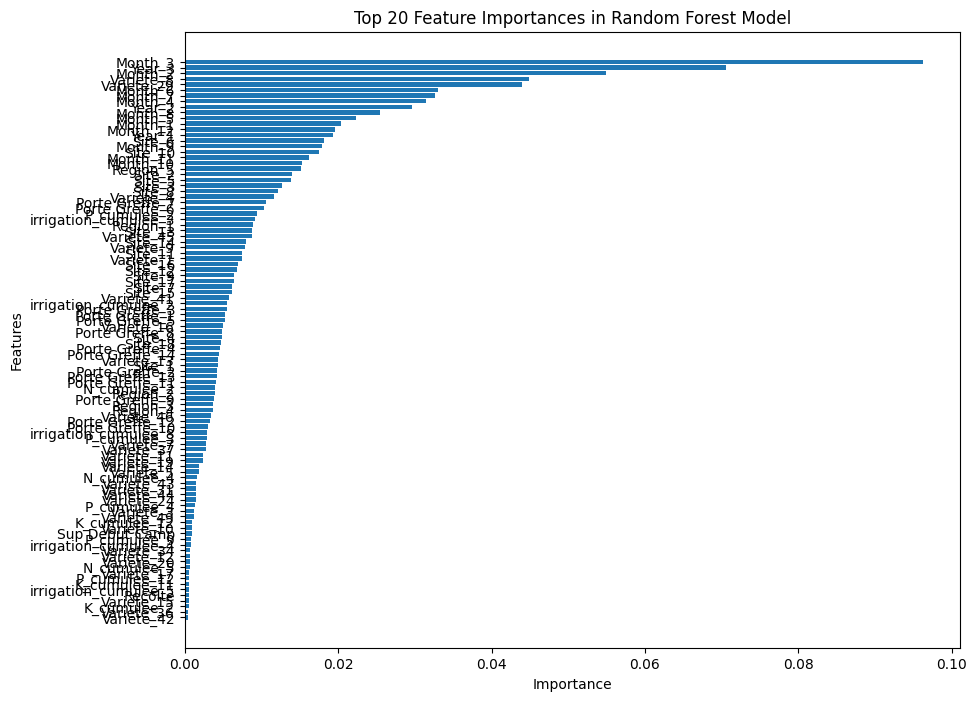

In [753]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # ... (your existing code to get feature_importances) ...

# # Plotting feature importances with improved visibility
# plt.figure(figsize=(10, 8))  # Increase figure size
# top_n = 100  # Number of top features to select, for example, the top 20
# top_features = feature_importances.head(top_n)  # Select top N features

# # Create a horizontal bar plot for better visibility
# plt.barh(top_features['feature'], top_features['importance'])
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.title('Top 20 Feature Importances in Random Forest Model')
# plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
# plt.show()


In [686]:
# # Access the linear regression model
# model = pipeline.named_steps['linearregression']

# # Extract the ColumnTransformer
# preprocessor = pipeline.named_steps['columntransformer']

# # Initialize an empty list to hold feature names
# transformed_feature_names = []

# # Iterate through each transformer in the ColumnTransformer
# for transformer_name, transformer, columns in preprocessor.transformers_:
#     if transformer_name != 'remainder':
#         if hasattr(transformer, 'get_feature_names_out'):
#             # If the transformer can generate feature names, use it
#             transformed_feature_names.extend(transformer.get_feature_names_out(columns))
#         else:
#             # Otherwise, use the original column names
#             transformed_feature_names.extend(columns)
#     else:
#         # For the 'remainder' transformer, add the remaining column names
#         transformed_feature_names.extend(columns)

# # If 'remainder' is 'passthrough', include remaining column names
# if preprocessor.remainder == 'passthrough':
#     remaining_cols = [col for col in X_train.columns if col not in cat_cols and col not in cols_to_impute]
#     transformed_feature_names.extend(remaining_cols)

# # Assuming model.coef_ contains the coefficients
# for feature_name, coef in zip(transformed_feature_names, model.coef_):
#     print(f'{feature_name}: {coef}')

In [745]:
pipeline.fit(X, y)
 
y_pred = pipeline.predict(X_test)

c:\Users\DataScience\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\DataScience\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [746]:
y_pred.shape

(781,)

In [689]:
y.mean()

Tonnage    20786.633094
dtype: float64

In [747]:
y_pred = np.array(y_pred)  # Convert to numpy array if not already
assert len(y_pred) == 781, "y_pred must have exactly 781 rows"

# Create a DataFrame. Adjust column names as per the competition's requirement.
# Usually, you will have an ID column and a prediction column.
submission_df = pd.DataFrame({
    'Id': range(1, 782),  # Example: creating a sequence of IDs from 1 to 781
    'Tonnage': y_pred
})

# Export to CSV
csv_file = "submission.csv"
submission_df.to_csv(csv_file, index=False)